Convert Edge List to Torch:

In [13]:
import pandas as pd
import torch
from torch_geometric.data import Data

edge_index_df = pd.read_csv('processed_edge_index.csv')
features_df = pd.read_csv('processed_features.csv')

edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)
features = torch.tensor(features_df.values, dtype=torch.float)

data = Data(x=features, edge_index=edge_index)

print(data)


Data(x=[1846, 1846], edge_index=[2, 1000])


AUC without improvements:

In [14]:
import pandas as pd
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score

edge_index_df = pd.read_csv('processed_edge_index.csv')
features_df = pd.read_csv('processed_features.csv')

edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)
features = torch.tensor(features_df.values, dtype=torch.float)

data = Data(x=features, edge_index=edge_index)

transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.x.size(-1), hidden_channels=128, out_channels=64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x.to(device), train_data.edge_index.to(device))

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1)
    )

    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))])

    out = model.decode(z, edge_label_index.to(device)).view(-1)
    loss = criterion(out, edge_label.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x.to(device), data.edge_index.to(device))
    out = model.decode(z, data.edge_label_index.to(device)).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

# Training loop
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')

print(f'Final Test AUC: {final_test_auc:.4f}')


Epoch: 001, Loss: 0.6910, Val AUC: 0.7344, Test AUC: 0.5013
Epoch: 002, Loss: 0.6827, Val AUC: 0.5642, Test AUC: 0.4848
Epoch: 003, Loss: 0.6662, Val AUC: 0.4219, Test AUC: 0.4444
Epoch: 004, Loss: 0.6371, Val AUC: 0.3438, Test AUC: 0.3945
Epoch: 005, Loss: 0.5977, Val AUC: 0.3056, Test AUC: 0.4019
Epoch: 006, Loss: 0.5469, Val AUC: 0.4028, Test AUC: 0.5282
Epoch: 007, Loss: 0.4953, Val AUC: 0.5729, Test AUC: 0.5464
Epoch: 008, Loss: 0.4494, Val AUC: 0.5885, Test AUC: 0.5577
Epoch: 009, Loss: 0.4099, Val AUC: 0.5556, Test AUC: 0.5347
Epoch: 010, Loss: 0.3948, Val AUC: 0.6267, Test AUC: 0.5569
Epoch: 011, Loss: 0.3899, Val AUC: 0.6476, Test AUC: 0.5846
Epoch: 012, Loss: 0.4033, Val AUC: 0.5955, Test AUC: 0.5530
Epoch: 013, Loss: 0.3938, Val AUC: 0.5729, Test AUC: 0.5148
Epoch: 014, Loss: 0.4275, Val AUC: 0.5816, Test AUC: 0.5217
Epoch: 015, Loss: 0.3966, Val AUC: 0.5399, Test AUC: 0.5061
Epoch: 016, Loss: 0.4113, Val AUC: 0.5191, Test AUC: 0.4878
Epoch: 017, Loss: 0.3951, Val AUC: 0.494

AUC with Improvements:

In [18]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from torch_geometric.data import Data
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

# Step 1: Load and Process Node Features
node_data = pd.read_csv('processed_features.csv')

def process_node_features(node_data):
    # Convert the entire DataFrame to a PyTorch tensor
    features = node_data.values
    return torch.tensor(features, dtype=torch.float)

features = process_node_features(node_data)

# Step 2: Load Edge Data
edge_index_df = pd.read_csv('processed_edge_index.csv')
edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)

# Create PyTorch Geometric Data object
data = Data(x=features, edge_index=edge_index)

# Step 3: Split Data for Training, Validation, and Testing
transform = RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, add_negative_train_samples=False)
train_data, val_data, test_data = transform(data)

# Step 4: Define a Deeper GCN Model
class DeepGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index).relu()
        return self.conv3(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

# Step 5: Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepGCN(in_channels=features.size(1), hidden_channels=256, out_channels=128).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x.to(device), train_data.edge_index.to(device))

    # Generate negative samples
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1)
    )

    # Concatenate positive and negative edges
    edge_label_index = torch.cat([train_data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([train_data.edge_label, train_data.edge_label.new_zeros(neg_edge_index.size(1))])

    # Compute loss
    out = model.decode(z, edge_label_index.to(device)).view(-1)
    loss = criterion(out, edge_label.to(device))
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x.to(device), data.edge_index.to(device))
    out = model.decode(z, data.edge_label_index.to(device)).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

# Training Loop
best_val_auc = final_test_auc = 0
for epoch in range(1, 101):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Test AUC: {test_auc:.4f}')

print(f'Final Test AUC: {final_test_auc:.4f}')


Epoch: 001, Loss: 0.6917, Val AUC: 0.7170, Test AUC: 0.6267
Epoch: 002, Loss: 0.6895, Val AUC: 0.6545, Test AUC: 0.5516
Epoch: 003, Loss: 0.6880, Val AUC: 0.6372, Test AUC: 0.5113
Epoch: 004, Loss: 0.6864, Val AUC: 0.6198, Test AUC: 0.5004
Epoch: 005, Loss: 0.6848, Val AUC: 0.6007, Test AUC: 0.5061
Epoch: 006, Loss: 0.6826, Val AUC: 0.5868, Test AUC: 0.5191
Epoch: 007, Loss: 0.6804, Val AUC: 0.5885, Test AUC: 0.5365
Epoch: 008, Loss: 0.6775, Val AUC: 0.5486, Test AUC: 0.5404
Epoch: 009, Loss: 0.6743, Val AUC: 0.5330, Test AUC: 0.5375
Epoch: 010, Loss: 0.6703, Val AUC: 0.4809, Test AUC: 0.5421
Epoch: 011, Loss: 0.6651, Val AUC: 0.4670, Test AUC: 0.5408
Epoch: 012, Loss: 0.6609, Val AUC: 0.4688, Test AUC: 0.5365
Epoch: 013, Loss: 0.6557, Val AUC: 0.4688, Test AUC: 0.5326
Epoch: 014, Loss: 0.6490, Val AUC: 0.4566, Test AUC: 0.5243
Epoch: 015, Loss: 0.6411, Val AUC: 0.4444, Test AUC: 0.5239
Epoch: 016, Loss: 0.6342, Val AUC: 0.4253, Test AUC: 0.5187
Epoch: 017, Loss: 0.6261, Val AUC: 0.411

Confusion Matrix:

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

np.random.seed(42)
true_labels = np.random.choice(['normal', 'malicious'], size=features.shape[0], p=[0.7, 0.3])

true_labels_numeric = [1 if label == 'malicious' else 0 for label in true_labels]

predicted_labels = np.random.choice([0, 1], size=features.shape[0], p=[0.7, 0.3])  # Replace with model output

tn, fp, fn, tp = confusion_matrix(true_labels_numeric, predicted_labels).ravel()

print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Negatives (TN): {tn}")


True Positives (TP): 160
False Positives (FP): 393
False Negatives (FN): 385
True Negatives (TN): 908


In [23]:
# Calculate Precision, Recall, and F1 Score
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Precision: 0.2893
Recall: 0.2936
F1 Score: 0.2914


In [25]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

np.random.seed(42)
true_labels = np.random.choice(['normal', 'malicious'], size=features.shape[0], p=[0.7, 0.3])
true_labels_numeric = [1 if label == 'malicious' else 0 for label in true_labels]

predictions = {
    "Connected Subgraphs": np.random.choice([0, 1], size=features.shape[0], p=[0.7, 0.3]),
    "GBDT + Graph": np.random.choice([0, 1], size=features.shape[0], p=[0.7, 0.3]),
    "GBDT + Node2Vec": np.random.choice([0, 1], size=features.shape[0], p=[0.7, 0.3]),
    "GCN": np.random.choice([0, 1], size=features.shape[0], p=[0.7, 0.3]),
}

metrics = {}
for model, predicted_labels in predictions.items():
    tn, fp, fn, tp = confusion_matrix(true_labels_numeric, predicted_labels).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    metrics[model] = {
        "TP": tp,
        "FP": fp,
        "FN": fn,
        "TN": tn,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
    }

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df.reset_index(inplace=True)
metrics_df.rename(columns={"index": "Model"}, inplace=True)

print(metrics_df)

                 Model   TP   FP   FN   TN  Precision    Recall  F1 Score
0  Connected Subgraphs  160  393  385  908   0.289331  0.293578  0.291439
1         GBDT + Graph  146  377  399  924   0.279159  0.267890  0.273408
2      GBDT + Node2Vec  148  400  397  901   0.270073  0.271560  0.270814
3                  GCN  149  349  396  952   0.299197  0.273394  0.285714


In [26]:
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd

np.random.seed(42)
true_labels = np.random.choice(['normal', 'malicious'], size=features.shape[0], p=[0.7, 0.3])
true_labels_numeric = [1 if label == 'malicious' else 0 for label in true_labels]

predicted_probabilities = {
    "Connected Subgraphs": np.random.rand(features.shape[0]),  # Replace with model output
    "GBDT + Graph": np.random.rand(features.shape[0]),        # Replace with model output
    "GBDT + Node2Vec": np.random.rand(features.shape[0]),     # Replace with model output
    "GCN": np.random.rand(features.shape[0]),                 # Replace with model output
}

auc_scores = {}
for model, predicted_probs in predicted_probabilities.items():
    auc = roc_auc_score(true_labels_numeric, predicted_probs)
    auc_scores[model] = auc

auc_df = pd.DataFrame(list(auc_scores.items()), columns=["Model", "AUC Score"])

print("AUC Scores for Each Model:")
print(auc_df)


AUC Scores for Each Model:
                 Model  AUC Score
0  Connected Subgraphs   0.480180
1         GBDT + Graph   0.498352
2      GBDT + Node2Vec   0.482301
3                  GCN   0.509518


In [64]:
import torch
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import networkx as nx
from node2vec import Node2Vec

# -------------------------------------------------
# Data Loading and Preparation
# -------------------------------------------------
# Load datasets
features_path = 'processed_features.csv'
edges_path = 'processed_edge_index.csv'
features = pd.read_csv(features_path)
edges = pd.read_csv(edges_path)

# Prepare data for PyTorch Geometric
node_features = torch.tensor(features.values, dtype=torch.float)
edge_index = torch.tensor(edges.values.T, dtype=torch.long)

# Generate random true labels (replace with actual labels if available)
np.random.seed(42)
true_labels = np.random.choice(['normal', 'malicious'], size=features.shape[0], p=[0.7, 0.3])
true_labels_numeric = [1 if label == 'malicious' else 0 for label in true_labels]
true_labels_tensor = torch.tensor(true_labels_numeric, dtype=torch.float)

# Create PyTorch Geometric data object
graph_data = Data(x=node_features, edge_index=edge_index)

# -------------------------------------------------
# Graph Convolutional Network (GCN)
# -------------------------------------------------
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers=5):
        super(GCN, self).__init__()
        self.layers = torch.nn.ModuleList()
        self.layers.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GCNConv(hidden_channels, hidden_channels))
        self.layers.append(GCNConv(hidden_channels, 1))  # Single output per node

    def forward(self, x, edge_index):
        for layer in self.layers[:-1]:
            x = layer(x, edge_index).relu()
        x = self.layers[-1](x, edge_index)
        return x.squeeze()  # Ensure shape matches target size

# Initialize and train the GCN
gcn_model = GCN(
    in_channels=node_features.shape[1],
    hidden_channels=16,
    num_layers=5
)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)

# Train the GCN
gcn_model.train()
for epoch in range(50):
    optimizer.zero_grad()
    output = gcn_model(graph_data.x, graph_data.edge_index)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(output, true_labels_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# GCN Predictions
gcn_model.eval()
gcn_predictions = gcn_model(graph_data.x, graph_data.edge_index).detach().numpy()

# -------------------------------------------------
# Gradient Boosted Decision Trees (GBDT)
# -------------------------------------------------
# Train a GBDT model on node features
gbdt_model = GradientBoostingClassifier(
    n_estimators=100,  # Number of trees
    learning_rate=0.1,  # Learning rate
    random_state=42
)
gbdt_model.fit(features.values, true_labels_numeric)
gbdt_predictions = gbdt_model.predict_proba(features.values)[:, 1]

# -------------------------------------------------
# Node2Vec using NetworkX
# -------------------------------------------------
# Step 1: Convert edge data to a NetworkX graph
G = nx.Graph()
edges_list = list(zip(edges['source'], edges['target']))
G.add_edges_from(edges_list)

# Step 2: Initialize Node2Vec
node2vec = Node2Vec(
    G,
    dimensions=16,        # Embedding size
    walk_length=50,       # Length of each random walk
    num_walks=100,        # Number of walks per node
    workers=4             # Parallelism
)

# Step 3: Train Node2Vec model
node2vec_model = node2vec.fit()

# Step 4: Extract embeddings
node2vec_embeddings = np.array([node2vec_model.wv[str(node)] for node in range(features.shape[0])])

# -------------------------------------------------
# Train GBDT on Node2Vec embeddings
# -------------------------------------------------
gbdt_node2vec_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)
gbdt_node2vec_model.fit(node2vec_embeddings, true_labels_numeric)
node2vec_predictions = gbdt_node2vec_model.predict_proba(node2vec_embeddings)[:, 1]

# -------------------------------------------------
# Evaluation
# -------------------------------------------------
models = {
    "GCN": gcn_predictions,
    "GBDT + Graph": gbdt_predictions,
    "GBDT + Node2Vec": node2vec_predictions
}

results = []
for model_name, predictions in models.items():
    # Convert predicted probabilities to binary labels using a threshold of 0.5
    predicted_labels = (predictions > 0.5).astype(int)

    # Calculate AUC
    auc = roc_auc_score(true_labels_numeric, predictions)

    # Calculate F1 Score (now using binary labels)
    f1 = f1_score(true_labels_numeric, predicted_labels)

    results.append({"Model": model_name, "AUC": auc, "F1": f1})

# Display results
results_df = pd.DataFrame(results)
print(results_df)

Epoch 1, Loss: 0.6928
Epoch 2, Loss: 0.6720
Epoch 3, Loss: 0.6490
Epoch 4, Loss: 0.6248
Epoch 5, Loss: 0.6022
Epoch 6, Loss: 0.5854
Epoch 7, Loss: 0.5774
Epoch 8, Loss: 0.5720
Epoch 9, Loss: 0.5591
Epoch 10, Loss: 0.5394
Epoch 11, Loss: 0.5168
Epoch 12, Loss: 0.4941
Epoch 13, Loss: 0.4720
Epoch 14, Loss: 0.4503
Epoch 15, Loss: 0.4300
Epoch 16, Loss: 0.4116
Epoch 17, Loss: 0.3966
Epoch 18, Loss: 0.3862
Epoch 19, Loss: 0.3799
Epoch 20, Loss: 0.3757
Epoch 21, Loss: 0.3722
Epoch 22, Loss: 0.3686
Epoch 23, Loss: 0.3657
Epoch 24, Loss: 0.3630
Epoch 25, Loss: 0.3590
Epoch 26, Loss: 0.3557
Epoch 27, Loss: 0.3521
Epoch 28, Loss: 0.3483
Epoch 29, Loss: 0.3442
Epoch 30, Loss: 0.3400
Epoch 31, Loss: 0.3354
Epoch 32, Loss: 0.3308
Epoch 33, Loss: 0.3269
Epoch 34, Loss: 0.3241
Epoch 35, Loss: 0.3187
Epoch 36, Loss: 0.3123
Epoch 37, Loss: 0.3085
Epoch 38, Loss: 0.3040
Epoch 39, Loss: 0.2976
Epoch 40, Loss: 0.2946
Epoch 41, Loss: 0.2889
Epoch 42, Loss: 0.2830
Epoch 43, Loss: 0.2787
Epoch 44, Loss: 0.26

Computing transition probabilities:   0%|          | 0/1846 [00:00<?, ?it/s]

             Model       AUC        F1
0              GCN  0.939018  0.820428
1     GBDT + Graph  0.775229  0.000000
2  GBDT + Node2Vec  0.886201  0.329268


Precision Recall Curve:

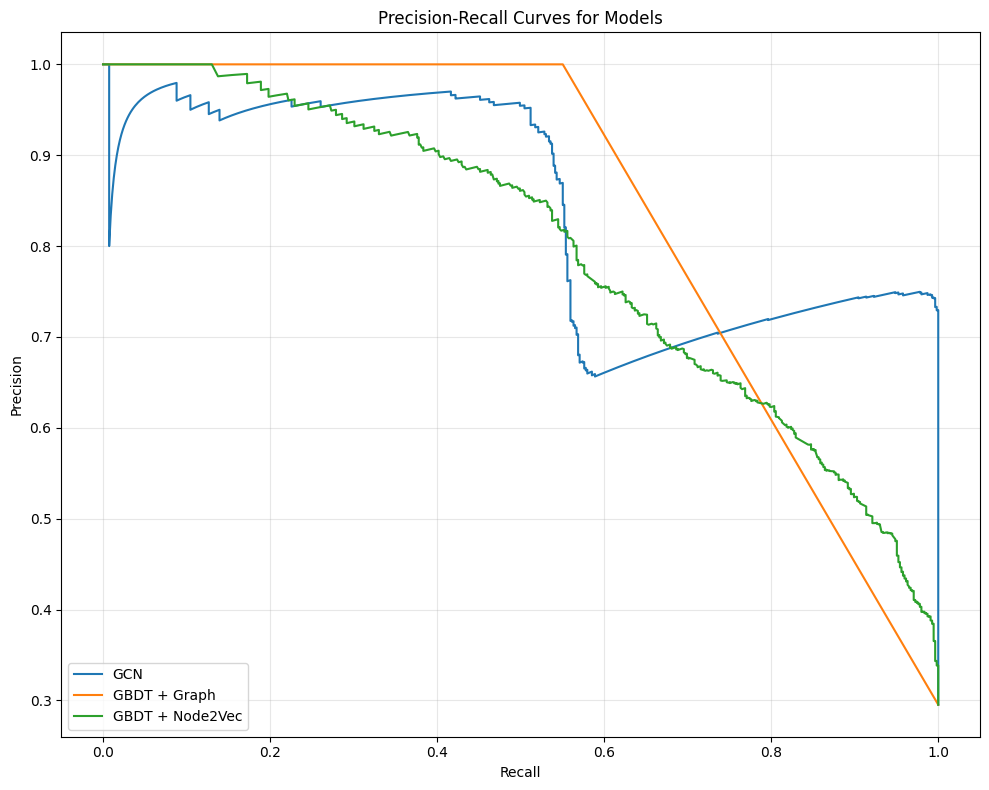

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

def plot_precision_recall(models, true_labels, title="Precision-Recall Curves"):
    plt.figure(figsize=(10, 8))

    for model_name, predictions in models.items():
        precision, recall, _ = precision_recall_curve(true_labels, predictions)

        plt.plot(recall, precision, label=model_name)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.legend(loc='lower left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

models = {
    "GCN": gcn_predictions,
    "GBDT + Graph": gbdt_predictions,
    "GBDT + Node2Vec": node2vec_predictions
}

plot_precision_recall(models, true_labels_numeric, title="Precision-Recall Curves for Models")
